# Add skyview factor to feature set

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import os

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

In [2]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)


C:\Users\kasj\AppData\Local\Temp\ipykernel_10464\1073794623.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
data.columns

Index(['RGIID', 'GLIMSID', 'BREID', 'utm_zone', 'utm_east_approx',
       'utm_north_approx', 'altitude_approx', 'location_description',
       'location_id', 'stake_no',
       ...
       'tp_jan', 'tp_feb', 'tp_mar', 'tp_apr', 'tp_may', 'tp_jun', 'tp_jul',
       'tp_aug', 'tp_sep', 'altitude_climate'],
      dtype='object', length=301)

In [10]:
# Function to add skyview_factor to gridded_data
def add_svf_to_gridded_data(svf_path, gridded_data_path, output_path):
    # Open SVF data
    svf_ds = xr.open_dataset(svf_path)
    svf_var = svf_ds['__xarray_dataarray_variable__']  # '__xarray_dataarray_variable__' is the default name if not specified
    
    # Rename the variable to "skyview_factor"
    svf_var = svf_var.rename("skyview_factor")

    # Open gridded data
    gridded_ds = xr.open_dataset(gridded_data_path)

    # Adjust the coordinates of svf_var to match gridded_data
    svf_var = svf_var.assign_coords({
        "x": gridded_ds.coords["x"],
        "y": gridded_ds.coords["y"]
    })

    # Merge the SVF variable into the gridded dataset
    combined_ds = gridded_ds.assign({"skyview_factor": svf_var})

    # Save the result
    combined_ds.to_netcdf(output_path)

# Main function to iterate through all subdirectories
def main(train_dir):
    for subdir in os.listdir(train_dir):
        subdir_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subdir_path) and subdir.startswith('RGI60-08'):
            svf_path = os.path.join(subdir_path, 'svf.nc')
            gridded_data_path = os.path.join(subdir_path, 'gridded_data.nc')
            output_path = os.path.join(subdir_path, 'gridded_data_svf.nc')
            if os.path.exists(svf_path) and os.path.exists(gridded_data_path):
                print(f"Processing {subdir_path}")
                add_svf_to_gridded_data(svf_path, gridded_data_path, output_path)
            else:
                print(f"Missing svf.nc or gridded_data.nc in {subdir_path}")

if __name__ == '__main__':
    train_dir = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test'
    main(train_dir)

Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.00434
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.00449
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01013
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01026
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01258
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01286
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01484
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01598
Missing svf.nc or gridded_data.nc in C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.02384
M

In [7]:
ds_svf

<xarray.Dataset>
Dimensions:                  (x: 74, y: 100)
Coordinates:
  * x                        (x) float32 -709.4 -680.4 ... 1.379e+03 1.408e+03
  * y                        (y) float32 6.662e+06 6.662e+06 ... 6.659e+06
Data variables: (12/21)
    topo                     (y, x) float32 ...
    topo_smoothed            (y, x) float32 ...
    topo_valid_mask          (y, x) int8 ...
    glacier_mask             (y, x) int8 ...
    glacier_ext              (y, x) int8 ...
    consensus_ice_thickness  (y, x) float32 ...
    ...                       ...
    slope_factor             (y, x) float32 ...
    dis_from_border          (y, x) float32 ...
    catchment_area           (y, x) float32 ...
    lin_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z          (y, x) float32 ...
    skyview_factor           (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.438 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1593.0
    min_h_dem:      1054.0
    max_h_glacier:  1593.0
    min_h_glacier:  1095.0

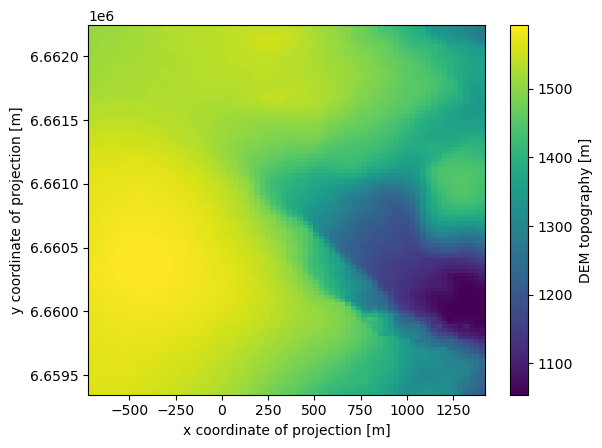

In [8]:
ds_svf['topo'].plot()


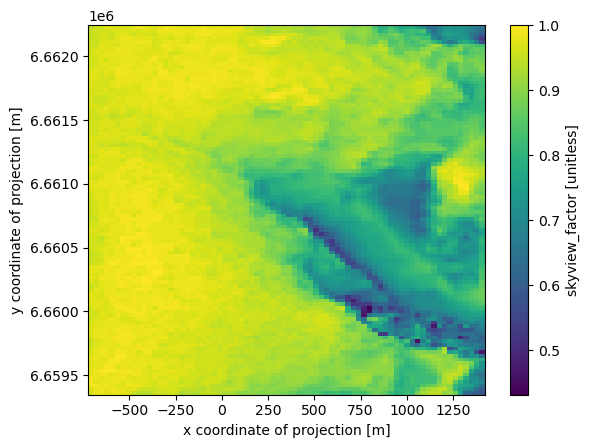

In [9]:
ds_svf['skyview_factor'].plot()

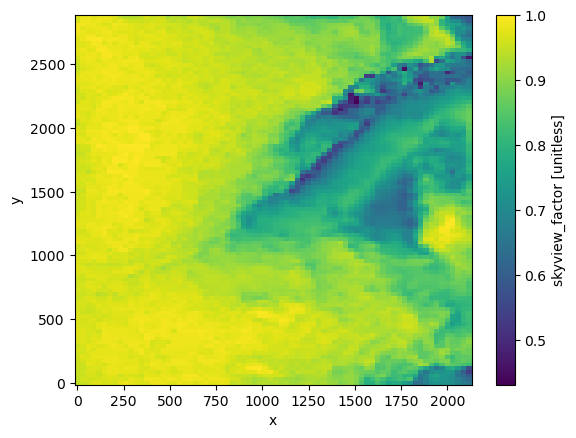

In [26]:
svf_var.plot()